# fit1T mode1 

In [1]:
                                                                                                                    import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

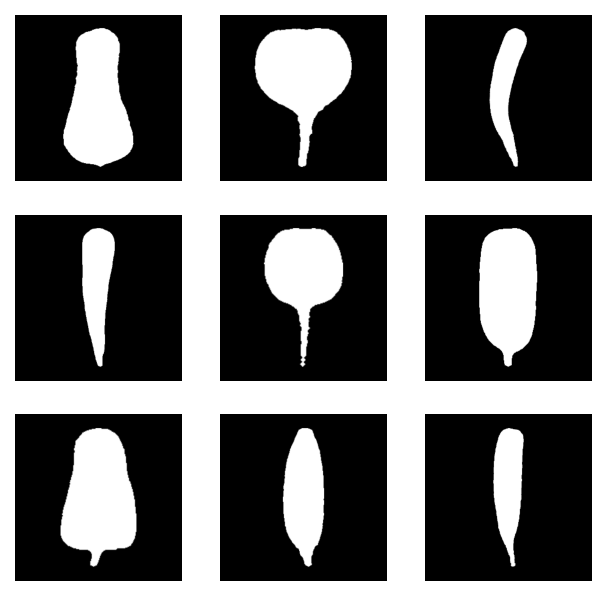

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0])
    return odds # 

In [5]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1T(tpara=[],mode=mode,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,(err,trynum) = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True,withEC=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return trynum,err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

# fit1T mode 1

# メモ
以下の実験ではオーバフィッティング判定を0.5×平均区間長として実験しているが、停止条件となっている誤り誤差にも比例させるべきなので論文にまとめる際には、0.5 の代わりに、err_th をあてはめて結果を読み替える。


# fitT mode 1
## img 0

...................................................................................................
CP 5.0, steps:98, etime: 52.67188 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.81250 err: 1.9688029781
............................E

[] [array([1.70753352, 2.30762488, 2.80096123, 2.79890202])]


(0.9923874903686253, array([], dtype=int64))

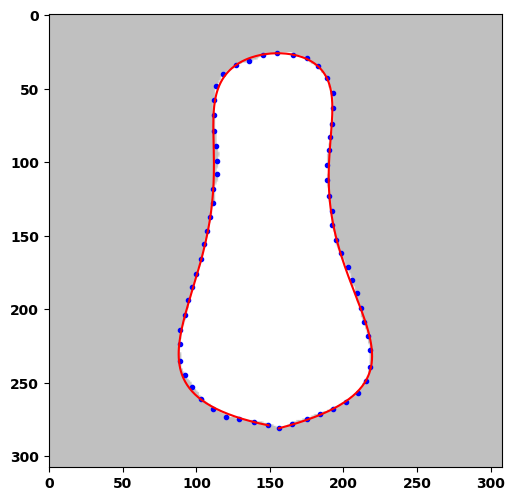

In [44]:
testOF(imgn=0,N=7,mode=1,err_th=1)

...................................................................................................
CP 5.0, steps:98, etime: 52.57812 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.82812 err: 1.9688029781
............................
CP 1.0, steps:158, etime: 83.35938 err: 0.9923874904
..............................E

[] [array([2.03449667])]


(0.6496268308769284, array([], dtype=int64))

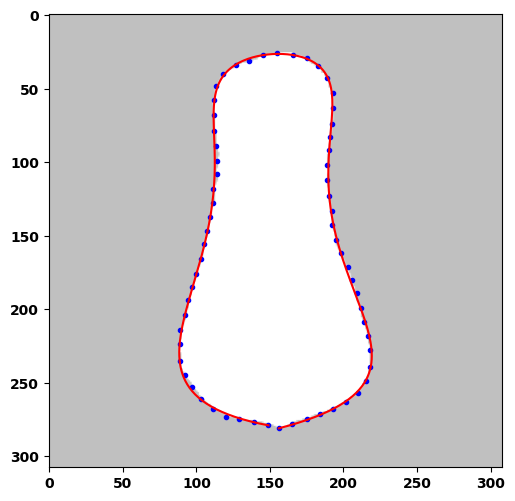

In [45]:
testOF(imgn=0,N=7,mode=1,err_th=0.65)

...................................................................................................
CP 5.0, steps:98, etime: 52.60938 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.85938 err: 1.9688029781
............................
CP 1.0, steps:158, etime: 83.07812 err: 0.9923874904
..............................
CP 0.65, steps:188, etime: 98.34375 err: 0.6496268309
...........
....................................................................................................
................................................................................^^^^^^^.^...........
............^^^^^^^^^^^^^^^^^^^^^^^.^^.^^.^^.^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^..^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5137207747772943, array([], dtype=int64))

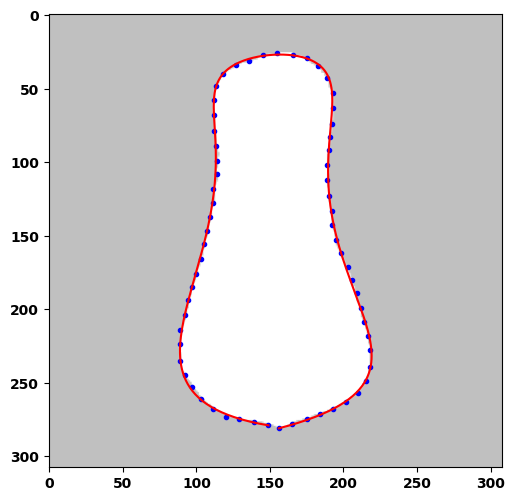

In [46]:
testOF(imgn=0,N=7,mode=1,err_th=0.5)

....................................................................................................
...............
CP 5.0, steps:114, etime: 141.65367 err: 4.9837201901
................................................
CP 2.0, steps:162, etime: 199.78454 err: 1.9793708483
.....................................
........
CP 1.0, steps:207, etime: 253.68333 err: 0.9889863222
.............................................................
CP 0.65, steps:268, etime: 326.71824 err: 0.6483804245
...............................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................................^^

(0.5094531424046116, array([], dtype=int64))

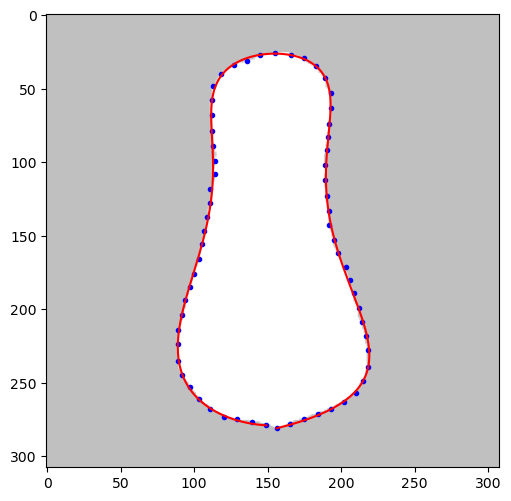

In [20]:
testOF1(imgn=0,N=8,err_th=0.5)

.....................................................................................
CP 5.0, steps:84, etime: 60.09375 err: 4.9085911684
...............
..........
CP 2.0, steps:109, etime: 76.84375 err: 1.9854089810
.....................
CP 1.0, steps:130, etime: 91.00000 err: 0.9817960167
..................
CP 0.65, steps:148, etime: 103.09375 err: 0.6443172570
.....................E

[] [array([1.83349963, 1.65517263])]


(0.4965834125046084, array([], dtype=int64))

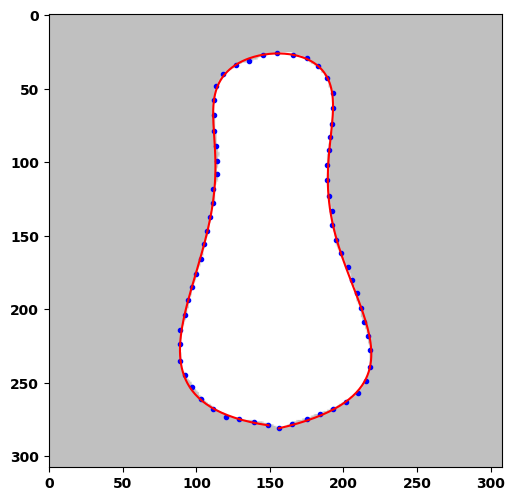

In [49]:
testOF(imgn=0,N=8,mode=1,err_th=0.5)

## img 1

..............................................................................................
CP 5.0, steps:93, etime: 84.25000 err: 4.9965848423
......
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................
CP 2.0, steps:629, etime: 551.18750 err: 1.9918016908
......................................................................
..........................................................E

[] [array([4.03674788, 3.89402765, 2.31199772, 2.36127527, 2.326711  ,
       5.48981355])]


(0.9981112885317548, array([], dtype=int64))

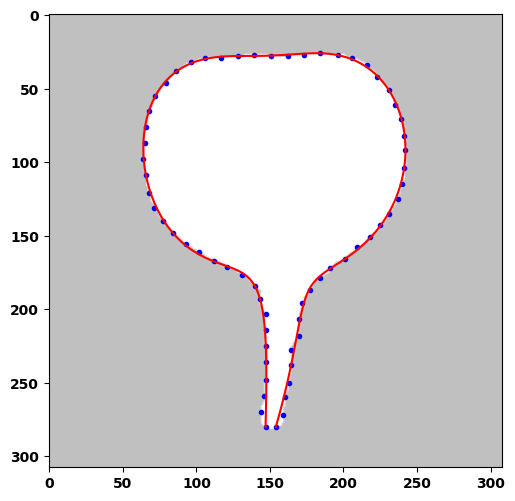

In [43]:
testOF(imgn=1,N=9,mode=1,err_th=1)

..............................................................................................
CP 5.0, steps:93, etime: 81.35938 err: 4.9965848423
......
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................
CP 2.0, steps:629, etime: 533.79688 err: 1.9918016908
......................................................................
..........................................................E

[] [array([4.03674788, 3.89402765, 2.31199772, 2.36127527, 2.326711  ,
       5.48981355])]


(0.9981112885317548, array([], dtype=int64))

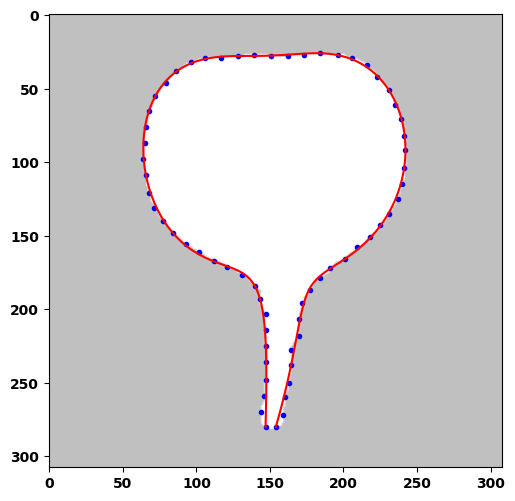

In [43]:
testOF(imgn=1,N=9,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 8.25000 err: 4.9053430804
........................................................................
CP 2.0, steps:75, etime: 81.82812 err: 1.9878677353
........................
..............................................................
CP 1.0, steps:161, etime: 169.54688 err: 0.9931436415
......................................
........................
CP 0.65, steps:223, etime: 233.18750 err: 0.6479230166
............................................................................
..............................................E

[] [array([1.82458897, 1.6452213 , 2.82140124, 2.34284038, 2.09274278])]


(0.49994577734864803, array([], dtype=int64))

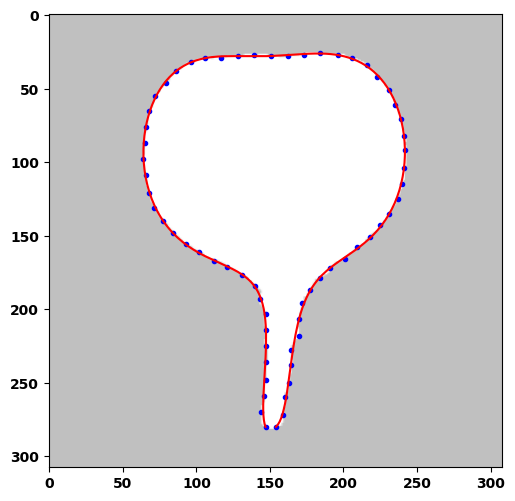

In [47]:
testOF(imgn=1,N=10,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 9.12500 err: 4.8226147760
........................................................................
CP 2.0, steps:75, etime: 82.75000 err: 1.9886757113
........................
.............................................................
CP 1.0, steps:160, etime: 170.71875 err: 0.9944535765
.......................................
.......................
CP 0.65, steps:222, etime: 234.32812 err: 0.6487741072
.............................................................................
.................................................E

[] [array([1.82871764, 2.02445713, 2.8651099 , 2.40172178, 1.99433878])]


(0.4999526885654096, array([], dtype=int64))

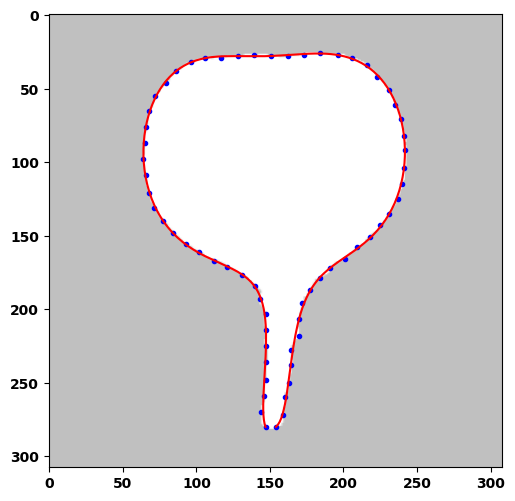

In [18]:
testOF(imgn=1,N=10,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 8.17188 err: 4.9053430804
........................................................................
CP 2.0, steps:75, etime: 80.12500 err: 1.9878677353
........................
..............................................................
CP 1.0, steps:161, etime: 167.17188 err: 0.9931436415
......................................
........................
CP 0.65, steps:223, etime: 229.20312 err: 0.6479230166
............................................................................
..............................................E
[] [array([1.82458897, 1.6452213 , 2.82140124, 2.34284038, 2.09274278])] (array([ 0,  8, 57, 58, 63], dtype=int64),) span 11.728316556662321


(345, 351.046875, 0.49994577734864803, array([], dtype=int64))

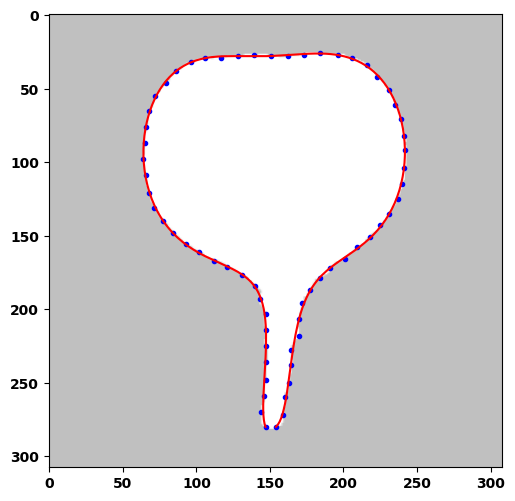

In [24]:
testOF(imgn=1,N=10,mode=1,err_th=0.5,of_th=0.5)

....
CP 5.0, steps:3, etime: 8.26562 err: 4.9053430804
........................................................................
CP 2.0, steps:75, etime: 81.09375 err: 1.9878677353
........................
..............................................................E

[] [array([2.70900909, 2.47640817, 2.78901931])]


(0.993143641451319, array([], dtype=int64))

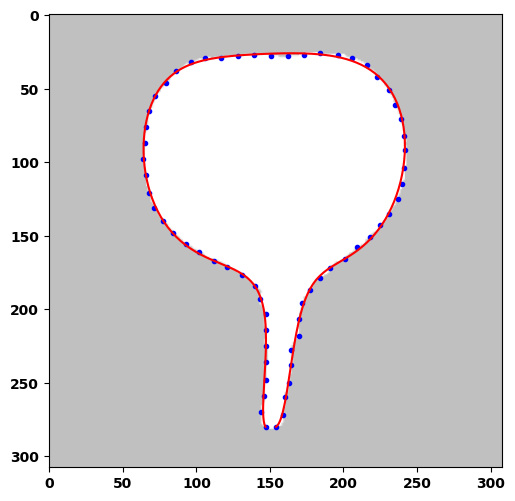

In [52]:
testOF(imgn=1,N=10,mode=1,err_th=1.0)

## img 2

...............
CP 5.0, steps:14, etime: 10.57475 err: 4.9898073657
........................................................
CP 2.0, steps:70, etime: 40.12369 err: 1.9858688823
.............................
....................................................................................................
....................................................................................................
...........................................................................^........................
.................................................^^.^...............................................
...........................................................^........................................
.................................^......................^^..............^........................
CP 1.0, steps:696, etime: 371.31167 err: 0.9998459751
...
...................^^..............................................................................^
..^......................^^..^.

(0.8624465581891688, array([], dtype=int64))

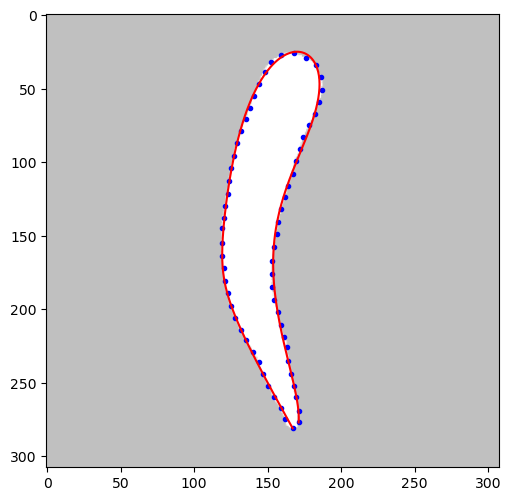

In [13]:
testOF(imgn=2,N=7,mode=1,err_th=0.5)

...............
CP 5.0, steps:14, etime: 10.26562 err: 4.9898051474
........................................................
CP 2.0, steps:70, etime: 37.76562 err: 1.9858640920
.............................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....^.........................................................................................^.....
..............^..........................................^^^.^................^.................E

[] [array([2.56502003, 2.39303048, 2.5667284 , 2.58490715, 2.17531283])]


(0.9998280552072191, array([], dtype=int64))

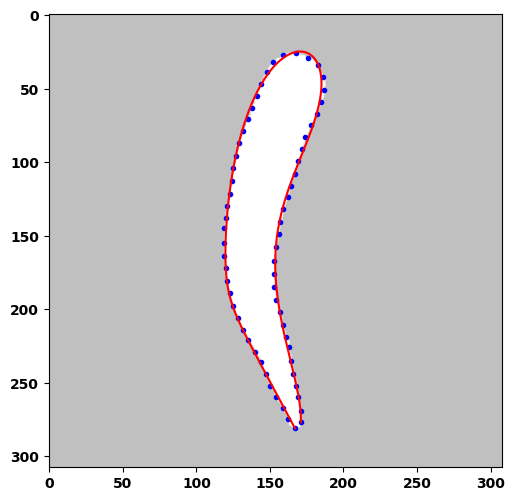

In [7]:
testOF(imgn=2,N=7,mode=1,err_th=1.0)

........
CP 5.0, steps:7, etime: 9.03479 err: 4.9471611967
...............
CP 2.0, steps:22, etime: 19.31692 err: 1.9777295795
.............................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............^....................................................................................
....................................................................................................
....................................................................................................
................^..^^...^...........................................................................
........................................................................................

(0.6499850325955578, array([], dtype=int64))

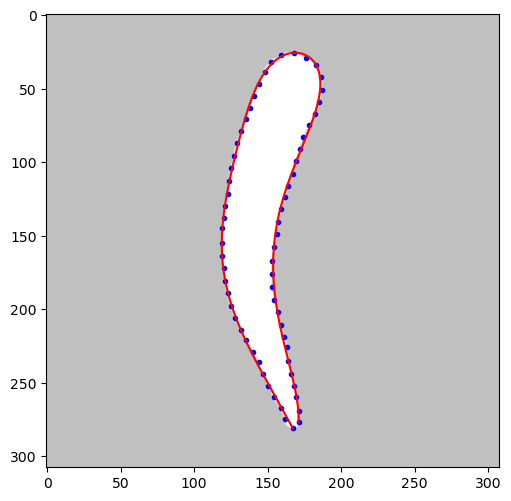

In [17]:
testOF(imgn=2,N=8,mode=1,err_th=0.65)

...
CP 5.0, steps:2, etime: 6.90180 err: 4.9255938190
........
CP 2.0, steps:10, etime: 14.06996 err: 1.9809158325
.......................................
CP 1.0, steps:49, etime: 48.34679 err: 0.9991841555
..................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................^..^...................................^....................
..................^......................................^...................................^^^....
.......^^^^^........^^^^...^....^..

(0.6499285689163732, array([], dtype=int64))

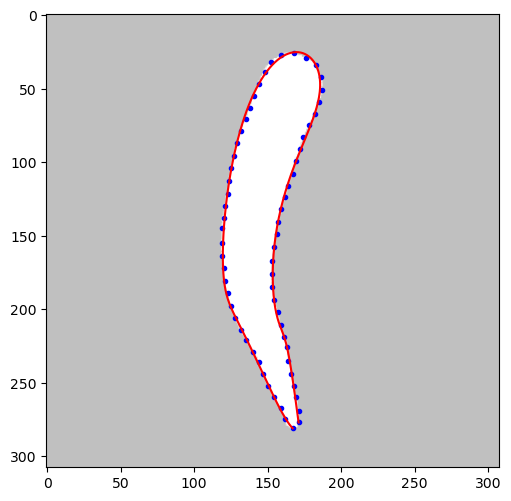

In [16]:
testOF(imgn=2,N=9,mode=1,err_th=0.65)

...
CP 5.0, steps:2, etime: 6.90180 err: 4.9255938190
........
CP 2.0, steps:10, etime: 14.06996 err: 1.9809158325
.......................................
CP 1.0, steps:49, etime: 48.34679 err: 0.9991841555
..................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................^..^...................................^....................
..................^......................................^...................................^^^....
.......^^^^^........^^^^...^....^..

(0.6499285689163732, array([], dtype=int64))

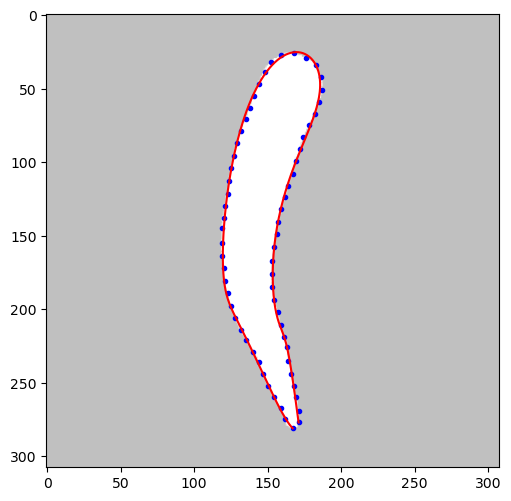

In [16]:
testOF(imgn=2,N=9,mode=1,err_th=0.65)

...
CP 5.0, steps:2, etime: 7.89349 err: 4.3019146474
.........
CP 2.0, steps:11, etime: 17.66793 err: 1.8700990691
..........................
CP 1.0, steps:37, etime: 45.94330 err: 0.9980446467
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................E


(0.6499145215959317, array([], dtype=int64))

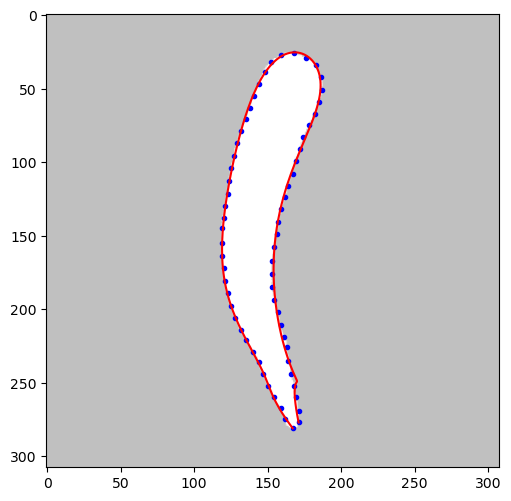

In [15]:
testOF(imgn=2,N=10,mode=1,err_th=0.65)

...
CP 5.0, steps:2, etime: 7.57819 err: 4.3019146474
.........
CP 2.0, steps:11, etime: 17.28943 err: 1.8700990691
..........................
CP 1.0, steps:37, etime: 45.02521 err: 0.9980446467
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................
CP 0.65, steps:449, etime: 488.31935 err: 0.6499145216
..................................................
....................................................................................................
...........^................^..........................^.^.............................^.^..........
........^^.^^.^^.^^.^^^^^..^^^^......................^...............^^^^^^.....

(0.4999921728388864, array([], dtype=int64))

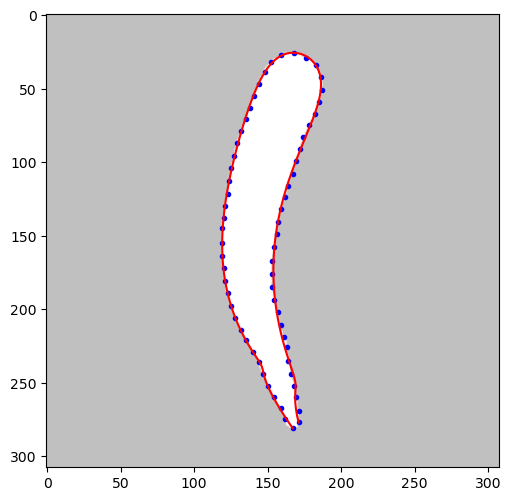

In [19]:
testOF(imgn=2,N=10,mode=1,err_th=0.5)

.
CP 5.0, steps:0, etime: 6.27530 err: 4.7731406358
...
CP 2.0, steps:3, etime: 10.17445 err: 1.9823871489
...............
CP 1.0, steps:18, etime: 29.68311 err: 0.9832535938
.................................................................................
CP 0.65, steps:99, etime: 134.96164 err: 0.6491934948

....................................................................................................
.............................................................................................E


(0.4997326133865579, array([], dtype=int64))

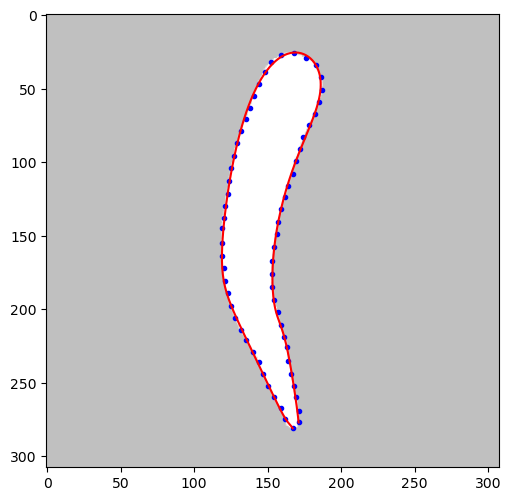

In [14]:
testOF(imgn=2,N=11,mode=1,err_th=0.5)

..
CP 5.0, steps:1, etime: 8.67188 err: 3.6063174974
...
CP 2.0, steps:4, etime: 12.29688 err: 1.9487501691
.................
CP 1.0, steps:21, etime: 32.84375 err: 0.9823981268
..............................................................................
....................................
CP 0.65, steps:135, etime: 171.25000 err: 0.6499256270
................................................................
....................................................................................................
.........................................................E

[] [array([], dtype=float64)]


(0.49996707160130355, array([], dtype=int64))

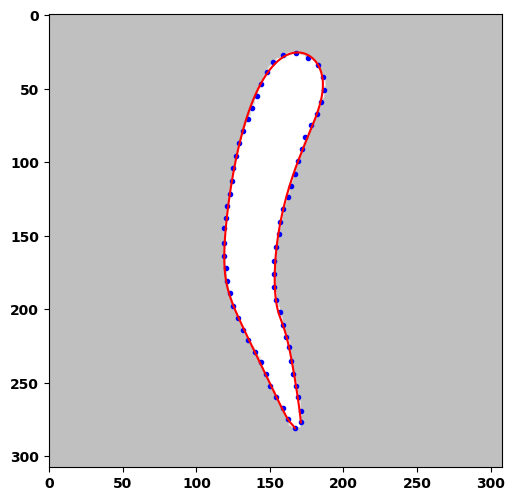

In [8]:
testOF(imgn=2,N=11,mode=1,err_th=0.5)

.
CP 5.0, steps:0, etime: 5.62500 err: 4.7731414878
...
CP 2.0, steps:3, etime: 9.29688 err: 1.9823850492
...............E

[] [array([2.21866942, 2.30912221])]


(0.9832486174480953, array([], dtype=int64))

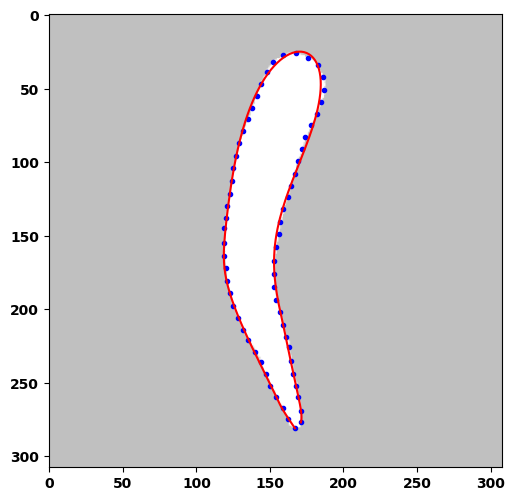

In [51]:
testOF(imgn=2,N=11,mode=1,err_th=1.0)

## img 3

....................................................................................................
....................................................................................................
........................
CP 5.0, steps:223, etime: 60.03125 err: 4.9843263271
............................................................................
.................................................
CP 2.0, steps:348, etime: 92.76562 err: 1.9930476600
...................................................
....................................................................................................
........................E
[] [array([1.66932946, 1.79110193, 2.38059953, 1.99741844, 1.84994898])] (array([ 3, 34, 35, 36, 37], dtype=int64),) span 8.909502355381846


(0.9999458153340047,
 array([], dtype=int64),
 Matrix([
 [ 154.0*t**5 + 132.39889194424*t**4*(5 - 5*t) + 266.591188632065*t**3*(1 - t)**2 + 2691.59934528045*t**2*(1 - t)**3 + 884.151142596555*t*(1 - t)**4 + 161.0*(1 - t)**5],
 [280.0*t**5 + 248.155096273562*t**4*(5 - 5*t) - 3144.36572798502*t**3*(1 - t)**2 + 2963.02389394385*t**2*(1 - t)**3 - 834.870686086883*t*(1 - t)**4 + 279.0*(1 - t)**5]]))

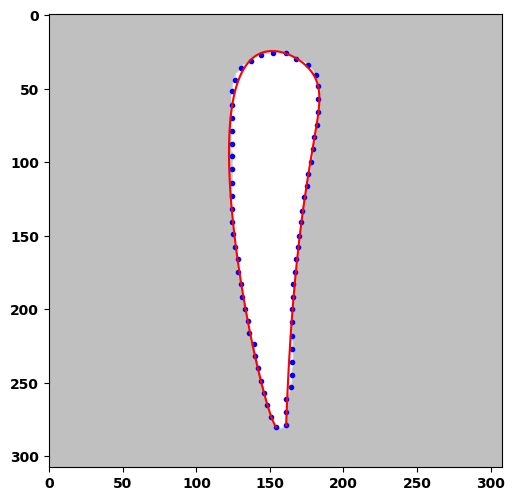

In [61]:
testOF(imgn=3,N=5,mode=1,err_th=1.0,of_th=1.0)

....................................................................................................
....................................................................................................
........................
CP 5.0, steps:223, etime: 60.07812 err: 4.9843263271
............................................................................
.................................................
CP 2.0, steps:348, etime: 92.75000 err: 1.9930476600
...................................................
....................................................................................................
........................E

[] [array([1.66932946, 1.79110193, 2.38059953, 1.99741844, 1.84994898])]


(0.9999458153340047, array([], dtype=int64))

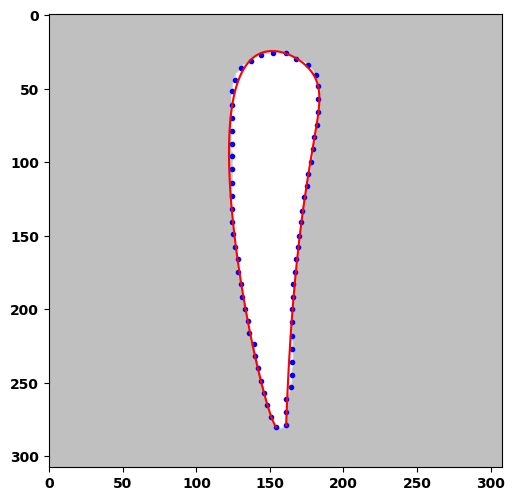

In [9]:
testOF(imgn=3,N=5,mode=1,err_th=1)

...................................................................
CP 5.0, steps:66, etime: 26.54688 err: 4.9813033700
.................................
...................................
CP 2.0, steps:134, etime: 51.68750 err: 1.9955004629
.................................................................
...........................................................
CP 1.0, steps:258, etime: 97.93750 err: 0.9992494671
.........................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................C



(0.8467174101255627, array([], dtype=int64))

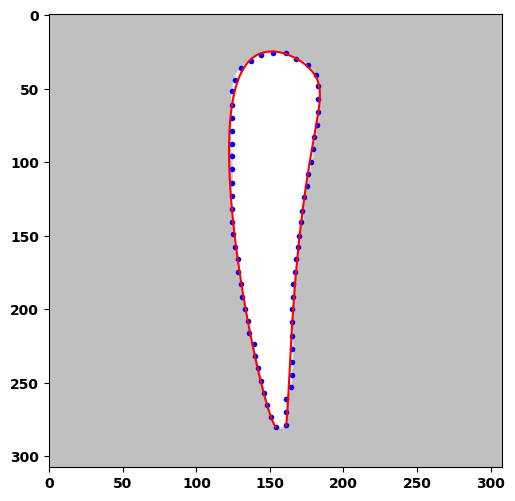

In [16]:
testOF(imgn=3,N=6,mode=1,err_th=0.65)

............................
CP 5.0, steps:27, etime: 16.54688 err: 4.9745638277
........................................................................
.........................................
CP 2.0, steps:140, etime: 73.68750 err: 1.9861723310
...........................................................
....................................................................................................
......................................
CP 1.0, steps:337, etime: 174.62500 err: 0.9990835237
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................^.........................
....................^..^......

(0.8390922362350557,
 array([], dtype=int64),
 Matrix([
 [154.0*t**7 + 137.446842335433*t**6*(7 - 7*t) + 3007.87675111059*t**5*(1 - t)**2 - 1467.25747804218*t**4*(1 - t)**3 + 12715.0601282276*t**3*(1 - t)**4 + 3062.02870724003*t**2*(1 - t)**5 + 1188.47418817727*t*(1 - t)**6 + 161.0*(1 - t)**7],
 [ 280.0*t**7 + 244.300275914636*t**6*(7 - 7*t) + 5358.62217582455*t**5*(1 - t)**2 - 20384.8004288599*t**4*(1 - t)**3 + 22475.4190787957*t**3*(1 - t)**4 - 8239.3022766779*t**2*(1 - t)**5 + 1714.35950976048*t*(1 - t)**6 + 279.0*(1 - t)**7]]))

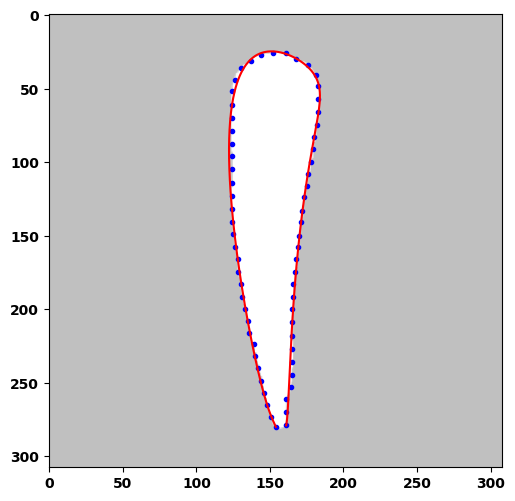

In [63]:
testOF(imgn=3,N=7,mode=1,err_th=0.65,of_th=0.65)

..................
CP 5.0, steps:17, etime: 15.23438 err: 4.8426560887
....................
CP 2.0, steps:37, etime: 28.35938 err: 1.9741953111
............................
CP 1.0, steps:65, etime: 46.67188 err: 0.9896702547
..................................
....................................^^..............................^^^.^.^.^.^.....................
..^^^^.^^^..................^^^^^^^.^.^^^^^^..^^^......^^^^^^^^^.^^..^.........^^^^^^^^^^^^^..^.^.^^
^....^.........^^^^^^^^^^^^^^^.^^^^.^^.....^^..^.^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^.^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^.^^^^^^^^^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.757507535284728, array([57], dtype=int64))

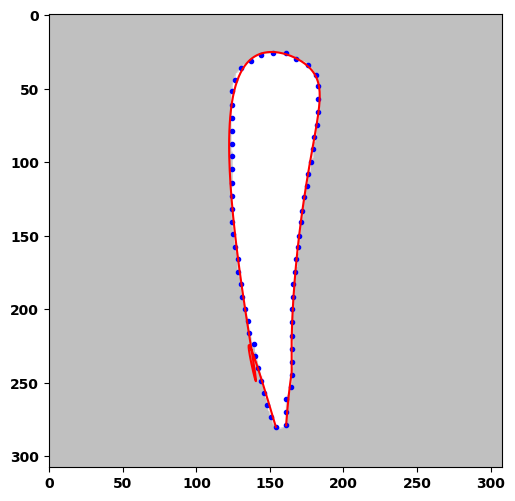

In [13]:
testOF(imgn=3,N=8,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.43750 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.65625 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 81.67188 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 150.71875 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

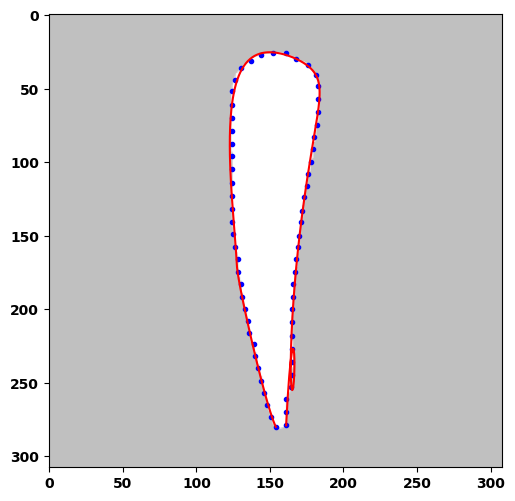

In [12]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.64062 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 40.26562 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 84.45312 err: 0.9966282212
......
..............................................................................E

[3] [array([ 2.04109192, 11.05902867,  2.12712078,  1.70211899,  1.4594852 ,
        1.51758148])]


(177, 0.6492956618836446, array([3], dtype=int64))

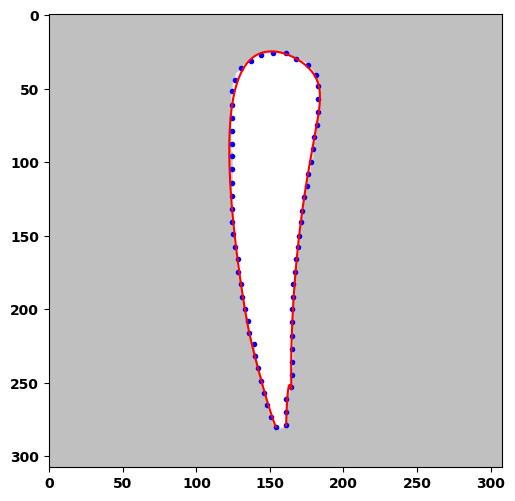

In [63]:
testOF(imgn=3,N=9,mode=1,err_th=0.65,of_th=0.65)

....
CP 5.0, steps:3, etime: 7.15625 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.18750 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 80.48438 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 149.64062 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

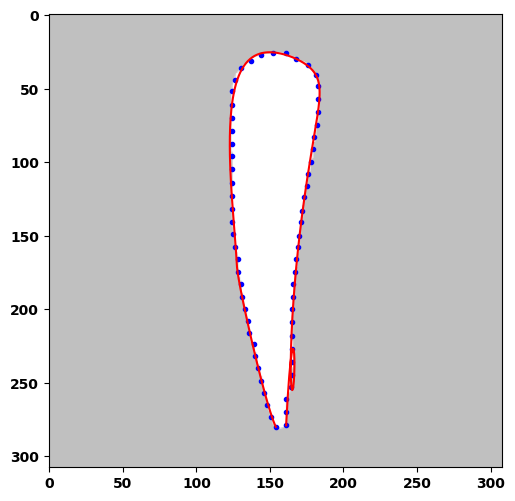

In [7]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.20312 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.04688 err: 1.9690211450
....................................................E

[] [array([2.55935656, 3.08687635, 2.06617803, 1.89289845])]


(0.9966282212148804, array([], dtype=int64))

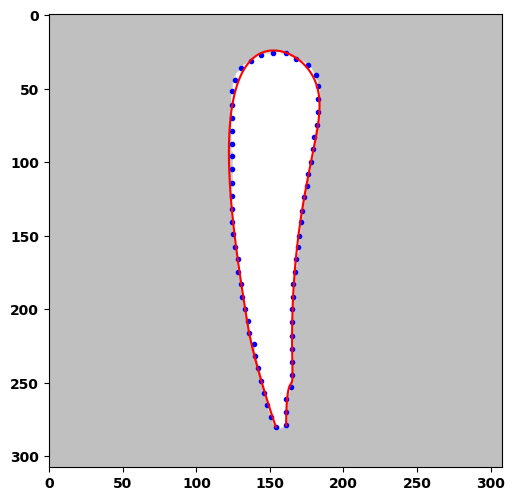

In [14]:
testOF(imgn=3,N=9,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 7.29688 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.43750 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 81.51562 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 151.40625 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

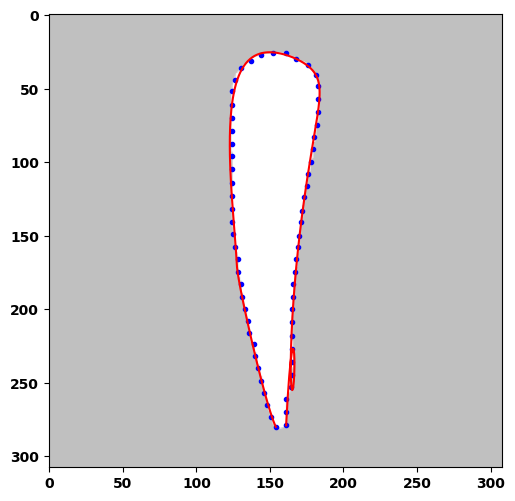

In [15]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.23438 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.20312 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 80.51562 err: 0.9966282212
......
..............................................................................E



(0.6492956618836446, array([], dtype=int64))

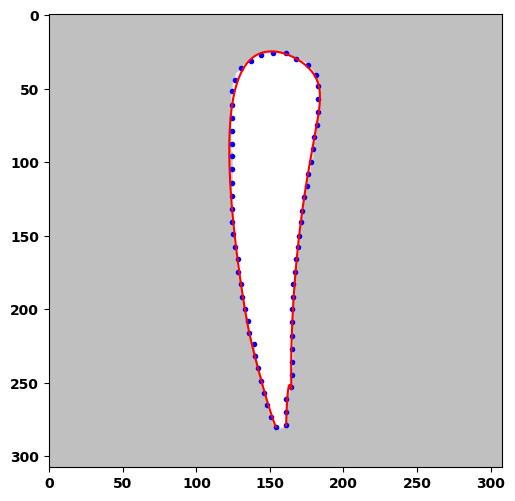

In [9]:
testOF(imgn=3,N=9,mode=1,err_th=0.65)

.....................................E



(0.4964976734959498, array([], dtype=int64))

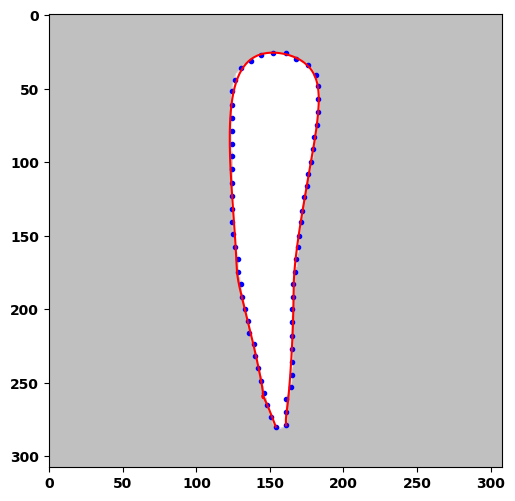

In [7]:
testOF(imgn=3,N=12,mode=1,err_th=0.5)

## img 4

........
CP 5.0, steps:7, etime: 12.40625 err: 4.9252023902
............................................................................................
.................................
CP 2.0, steps:132, etime: 140.17188 err: 1.9981042466
...................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................E



(0.9990928136624698, array([], dtype=int64))

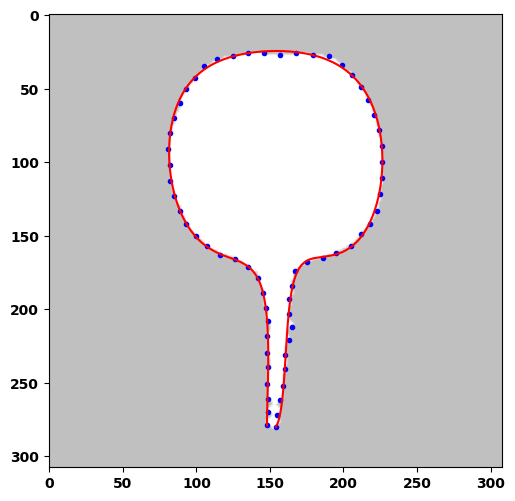

In [11]:
testOF(imgn=4,N=10,mode=1,err_th=1)

## img 5

..........
CP 5.0, steps:9, etime: 10.37500 err: 4.4105466618
................................................................................
CP 2.0, steps:89, etime: 64.15625 err: 1.9946919596
..........
....................................................................................................
..................................................E

[] [array([], dtype=float64)]


(249, 0.9971848174716987, array([], dtype=int64))

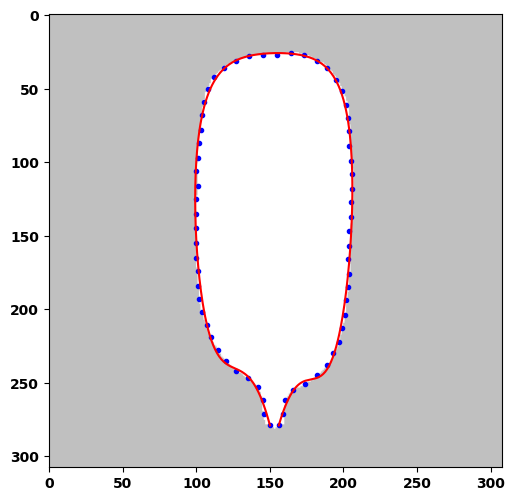

In [69]:
testOF(imgn=5,N=8,mode=1,err_th=1,of_th=1.0)

.
CP 5.0, steps:0, etime: 4.89062 err: 4.5710049162
.................
CP 2.0, steps:17, etime: 19.26562 err: 1.9949542574
..................................................................................
.
CP 1.0, steps:100, etime: 89.64062 err: 0.9944406448
............................................................................
CP 0.65, steps:176, etime: 154.06250 err: 0.6497770160
.......................
..........................................................E

[] [array([3.3680057 , 2.92356743, 2.9543816 ])]


(0.4997608145796149, array([], dtype=int64))

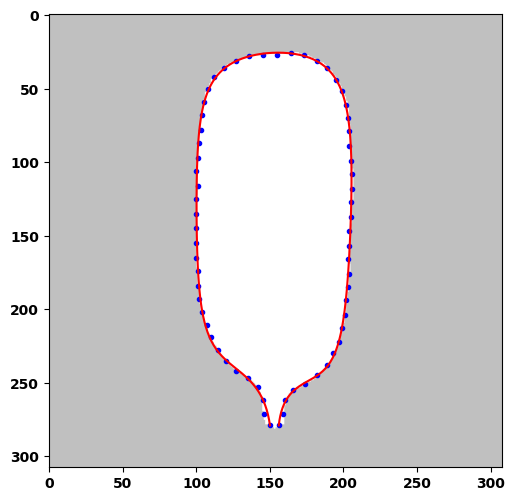

In [41]:
testOF(imgn=5,N=9,mode=1,err_th=0.5)

## img 6

..
CP 5.0, steps:1, etime: 6.93750 err: 4.9724672526
.................
CP 2.0, steps:18, etime: 27.43750 err: 1.9695702477
.....................................
CP 1.0, steps:55, etime: 72.89062 err: 0.9959101869
............................................
....................................................................................................
.............
CP 0.65, steps:212, etime: 262.46875 err: 0.6499797406
.......................................................................................
....................................................................................................
....................................................................................................
....^.^.^.^.^..^^...................................................................................
...^^..........^......^^.^..^^^^..^.^^.^^^^^^^^^....................................................
...........................^^........................^^^^^....^^^^^^^...^^^^....

(3000, 3637.875, 0.5780964657885953, array([], dtype=int64))

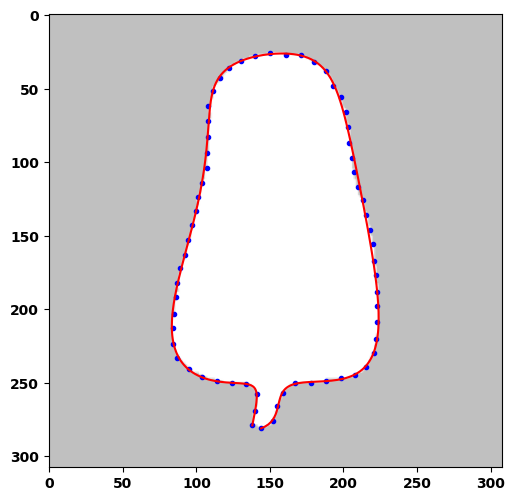

In [26]:
testOF(imgn=6,N=11,mode=1,err_th=0.5,of_th=0.5)

................
CP 5.0, steps:15, etime: 20.18750 err: 4.8939381189
....................................................................................
..............
CP 2.0, steps:113, etime: 119.18750 err: 1.9902368748
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^^^^...^^^.............^.^..........................
..........^.^.^...^.^..^..^..^..........^..^..^..^.^^^^^^^^^^^^.............^..^..^..^..^...^^^^.^^.
^^...................^^.....^..^^..^.^^...^......^...^^^^^^^^^^^^^^^^^^^^.^^^..^^..^

(2780, 2808.28125, 0.9999120460187123, array([], dtype=int64))

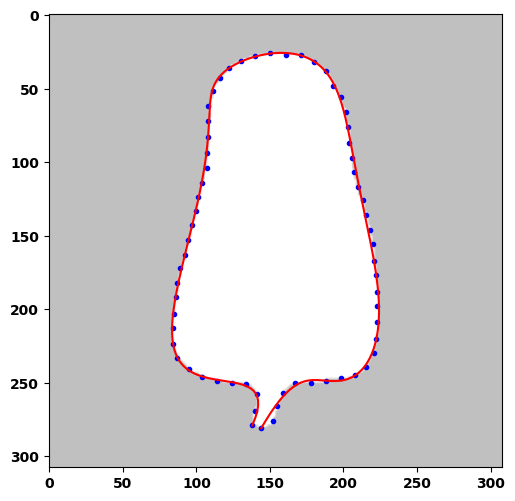

In [13]:
testOF(imgn=6,N=10,mode=1,err_th=1.0,of_th=1.0)

................
CP 5.0, steps:15, etime: 20.96875 err: 4.8939381189
....................................................................................
..............
CP 2.0, steps:113, etime: 124.17188 err: 1.9902368748
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^^^^...^^^.............^.^..........................
..........^.^.^...^.^..^..^..^..........^..^..^..^.^^^^^^^^^^^^.............^..^..^..^..^...^^^^.^^.
^^...................^^.....^..^^..^.^^...^......^...^^^^^^^^^^^^^^^^^^^^.^^^..^^..^

(2780, 0.9999120460187123, array([], dtype=int64))

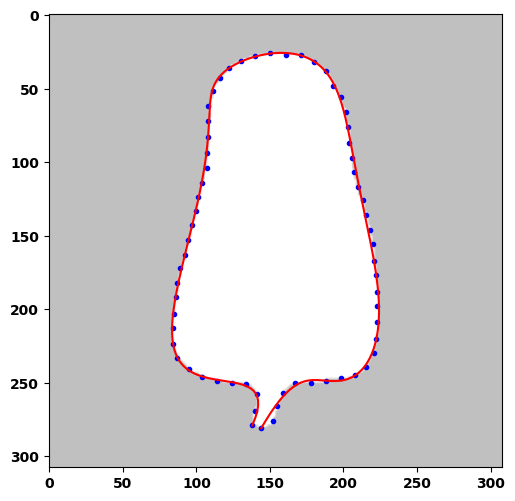

In [61]:
testOF(imgn=6,N=10,mode=1,err_th=1.0,of_th=1.0)

..
CP 5.0, steps:1, etime: 6.89062 err: 4.9724672526
.................
CP 2.0, steps:18, etime: 27.31250 err: 1.9695702477
.....................................
CP 1.0, steps:55, etime: 72.06250 err: 0.9959101869
............................................
....................................................................................................
.............E



(0.6499797405764021, array([], dtype=int64))

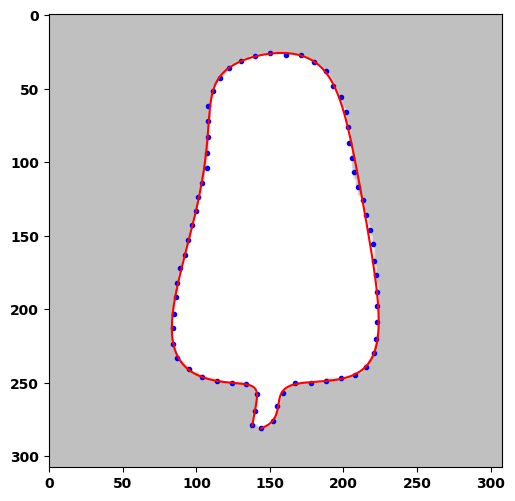

In [18]:
testOF(imgn=6,N=11,mode=1,err_th=0.65)

................
CP 5.0, steps:15, etime: 20.26562 err: 4.8939381189
....................................................................................
..............
CP 2.0, steps:113, etime: 119.10938 err: 1.9902368748
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^^^^...^^^.............^.^..........................
..........^.^.^...^.^..^..^..^..........^..^..^..^.^^^^^^^^^^^^.............^..^..^..^..^...^^^^.^^.
^^...................^^.....^..^^..^.^^...^......^...^^^^^^^^^^^^^^^^^^^^.^^^..^^..^

(3000, 3058.609375, 0.9976501364007768, array([], dtype=int64))

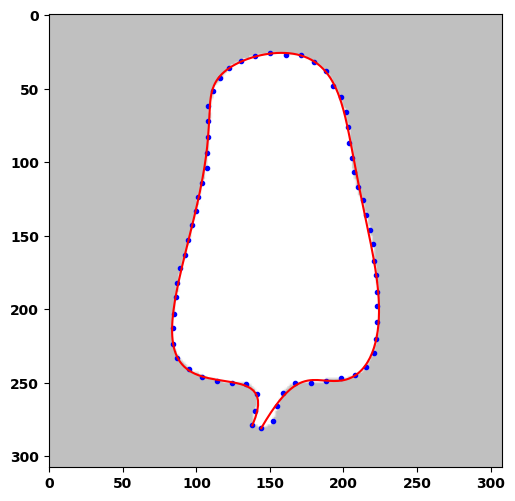

In [28]:
testOF(imgn=6,N=10,mode=1,err_th=0.9,of_th=0.9)

..
CP 5.0, steps:1, etime: 7.09375 err: 4.9724672526
.................
CP 2.0, steps:18, etime: 28.96875 err: 1.9695702477
.....................................
CP 1.0, steps:55, etime: 74.89062 err: 0.9959101869
............................................
....................................................................................................
.............E

[] [array([2.26775603, 2.32889789, 2.22496857])]


(0.6499797405764021, array([], dtype=int64))

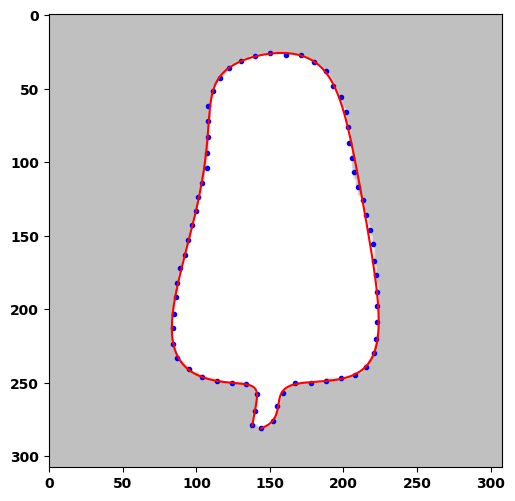

In [58]:
testOF(imgn=6,N=11,mode=1,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 6.01562 err: 3.5043842213
...........
CP 2.0, steps:11, etime: 21.76562 err: 1.9755567033
...........................
CP 1.0, steps:38, etime: 60.65625 err: 0.9919499326
............................
CP 0.65, steps:66, etime: 100.70312 err: 0.6479381433
.................................
.....................E



(0.4993418145857969, array([], dtype=int64))

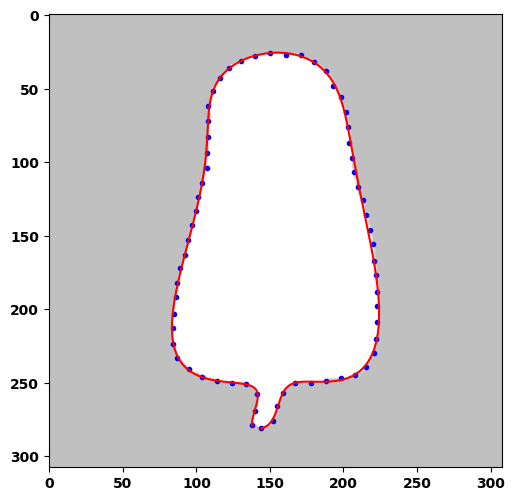

In [19]:
testOF(imgn=6,N=12,mode=1,err_th=0.5)

.
CP 5.0, steps:0, etime: 6.04688 err: 3.5043842213
...........
CP 2.0, steps:11, etime: 21.96875 err: 1.9755567033
...........................
CP 1.0, steps:38, etime: 61.03125 err: 0.9919499326
............................
CP 0.65, steps:66, etime: 101.50000 err: 0.6479381433
.................................
.....................E
[] [array([2.30169659, 1.62552156, 2.69587653])] (array([46, 47, 57], dtype=int64),) span 10.89222801849246


(120, 180.46875, 0.4993418145857969, array([], dtype=int64))

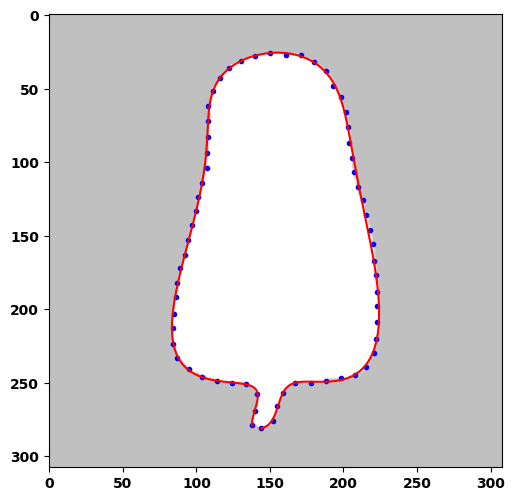

In [27]:
testOF(imgn=6,N=12,mode=1,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.56250 err: 3.2705896016
.....
CP 2.0, steps:5, etime: 15.04688 err: 1.9357076294
............................
CP 1.0, steps:33, etime: 62.53125 err: 0.9969282837
..................................
CP 0.65, steps:67, etime: 120.06250 err: 0.6491495867
................................
...................................E
[] [array([1.55138638, 1.74214683, 1.51134296, 1.93661739, 3.03061379])] (array([45, 46, 47, 55, 57], dtype=int64),) span 10.89222801849246


(134, 233.484375, 0.4999492273436219, array([], dtype=int64))

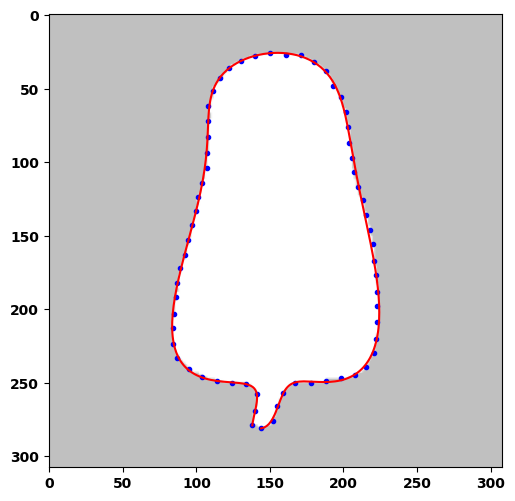

In [28]:
testOF(imgn=6,N=13,mode=1,err_th=0.5,of_th=0.5)

## img 7

....
CP 5.0, steps:3, etime: 3.28125 err: 4.3044265142
...
CP 2.0, steps:6, etime: 4.39062 err: 1.8457861020
..........................................................................E

[] [array([2.56362791, 2.55849979, 3.1369641 ])]


(0.9997393514565017, array([], dtype=int64))

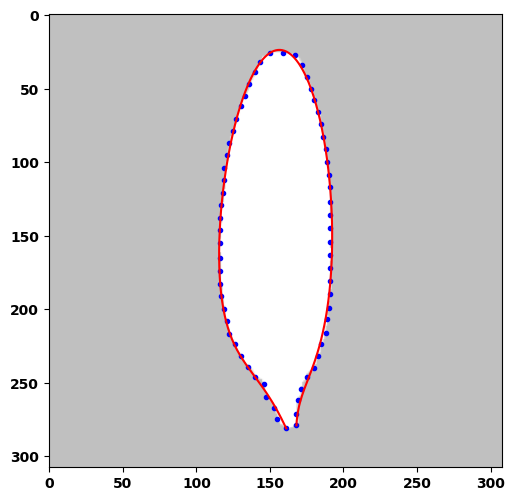

In [48]:
testOF(imgn=7,N=6,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 4.32812 err: 4.0570447133
...
CP 2.0, steps:6, etime: 5.79688 err: 1.5684979508
....
CP 1.0, steps:10, etime: 7.73438 err: 0.9950934095
.........................................................................................
..............
CP 0.65, steps:113, etime: 57.92188 err: 0.6493082898
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................^....................................^........................................^^...
...................................^^^.......................................^^.....

(0.49998392725923885, array([], dtype=int64))

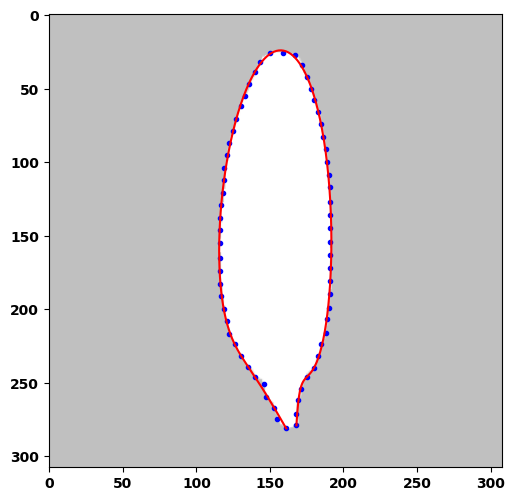

In [22]:
testOF(imgn=7,N=7,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 3.26562 err: 4.3044265142
...
CP 2.0, steps:6, etime: 4.35938 err: 1.8457861020
..........................................................................
CP 1.0, steps:80, etime: 31.10938 err: 0.9997393515
...................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................

(0.6499617296398823, array([], dtype=int64))

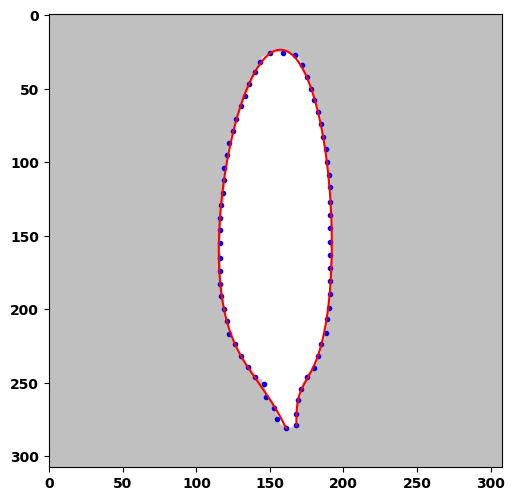

In [20]:
testOF(imgn=7,N=6,mode=1,err_th=0.65)

## img 8

.............
CP 5.0, steps:12, etime: 11.62500 err: 4.9143288917
...............................
CP 2.0, steps:43, etime: 31.70312 err: 1.9973247076
........................................................
....................................................................................................
^^.^...........................^^.^.^.^.........^^^.^.^........^......................^^^^^^^^.^^..^
............................^^^..^..^.............^^^^^^^.^.....^.^.^..............^^^^^.^.^^..^^...
^.....^^^..^..^^^^^^^..^^^...^^^^^^^.^^.^.^^^^^..^^.....^^.^^^^^.^.^..^.^^.^^^^^^^^^^^.^.^..........
...^^^^^^^^^^..........^^^....^..^...^.^.^^^^^^^^^^^^^^.^^^^.^^^^^^..........^^^^.^^.^.^.^^^^.^^.^..
^.........^^^^^^^^.^.^.^.^^^^^^^^.^.....^......^......^^^^^^^^..^...^^^^^^^.^.^..^.^^.^^^^.^..^..^^^
^..^^^^^^..^^^^.^^.^^..^^^^^.^.^^^^^^^^^.......^...^.^^^^^..^^^^^^^..^^.^^.^....^..^.^^.^^^^^^^^^^.^
^.^^...^^.^^^^^^^^^..^..^^..^^^^^.^...^^^..^^^.^^^^^.............^^^^^^.^^^.^^^^....^.

(0.9947144709202382, array([57], dtype=int64))

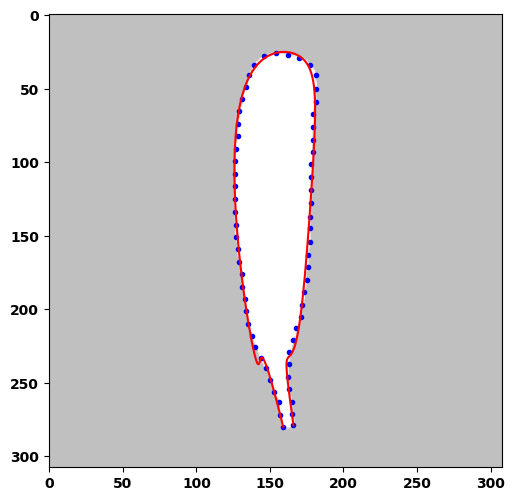

In [37]:
testOF(imgn=8,N=8,mode=1,err_th=1)

...
CP 5.0, steps:2, etime: 6.56250 err: 4.8923418547
..................................
CP 2.0, steps:36, etime: 34.12500 err: 1.9823473007
...............................................................
....................................................................................................
..................
CP 1.0, steps:217, etime: 181.51562 err: 0.9992883684
..................................................................................
...........................................................................
CP 0.65, steps:374, etime: 308.96875 err: 0.6488220548
.........................
..........................................................................E



(0.4992479828046801, array([], dtype=int64))

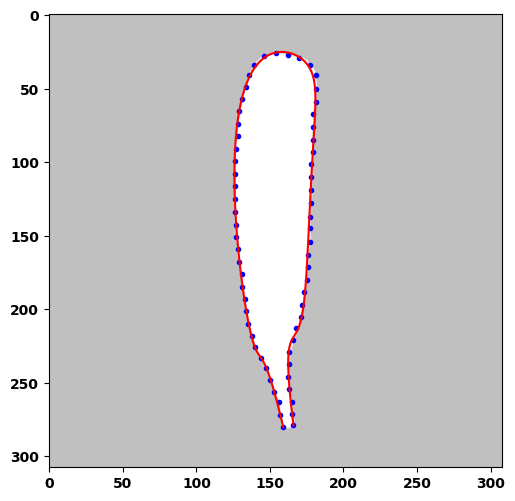

In [24]:
testOF(imgn=8,N=9,mode=1,err_th=0.5)

...
CP 5.0, steps:2, etime: 6.59375 err: 4.8923418547
..................................
CP 2.0, steps:36, etime: 35.03125 err: 1.9823473007
...............................................................
....................................................................................................
..................
CP 1.0, steps:217, etime: 188.07812 err: 0.9992883684
..................................................................................
...........................................................................
CP 0.65, steps:374, etime: 320.64062 err: 0.6488220548
.........................
..........................................................................E
[] [array([1.20719732, 1.20897482, 1.21295631, 1.19362289, 1.18924344,
       1.3826287 , 1.16566308, 1.19135779])] (array([ 6, 17, 25, 27, 28, 30, 31, 47], dtype=int64),) span 8.902570307254791


(0.4992479828046801,
 array([], dtype=int64),
 Matrix([
 [  159.0*t**9 + 120.691572414328*t**8*(9 - 9*t) + 5727.67943434877*t**7*(1 - t)**2 + 12989.911126914*t**6*(1 - t)**3 - 22169.0787129758*t**5*(1 - t)**4 + 83795.131449525*t**4*(1 - t)**5 - 12259.0341486567*t**3*(1 - t)**6 + 11722.4195138813*t**2*(1 - t)**7 + 1186.85771721905*t*(1 - t)**8 + 166.0*(1 - t)**9],
 [280.0*t**9 + 117.641076817125*t**8*(9 - 9*t) + 15371.1907909056*t**7*(1 - t)**2 + 17707.2856894125*t**6*(1 - t)**3 - 137062.456536617*t**5*(1 - t)**4 + 200417.615292023*t**4*(1 - t)**5 - 116919.908263099*t**3*(1 - t)**6 + 31750.2038514334*t**2*(1 - t)**7 + 70.3216399956653*t*(1 - t)**8 + 279.0*(1 - t)**9]]))

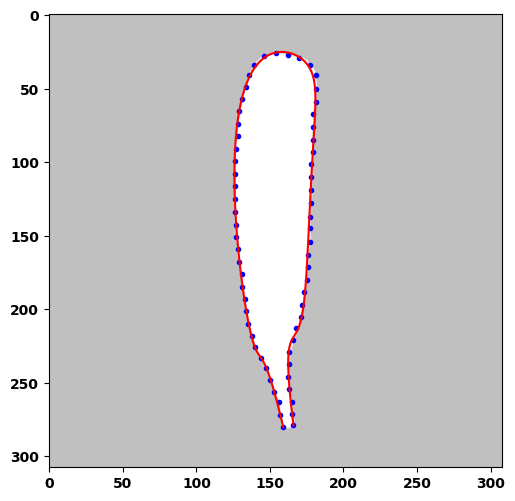

In [53]:
testOF(imgn=8,N=9,mode=1,err_th=0.5,of_th=0.5)